In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
import time
import math
import joblib
import torch

plt.style.use("dark_background")

/home/athekunal/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features_data = pd.read_csv('elliptic_txs_features.csv',header=None)
label_data = pd.read_csv('elliptic_txs_classes.csv')

features_data.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [3]:
features_data.rename(columns={0:"txId"},inplace=True)

In [4]:
label_data['class'].value_counts()

unknown    157205
2           42019
1            4545
Name: class, dtype: int64

In [5]:
label_data['class'].replace('unknown',0,inplace=True)
label_data['class'].replace('2',2,inplace=True)
label_data['class'].replace('1',1,inplace=True)

In [6]:
combined_data = pd.merge(features_data,label_data,how="left",on="txId")

In [7]:
combined_data.head()

,txId,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,0
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,0


In [8]:
local_cols = ['Local_Features_'+str(i) for i in range(1,94)]
agg_cols = ['Aggregate_Features_'+str(i) for i in range(94,166)]

combined_data.columns = ['txId','Time Step'] + local_cols + agg_cols + ['class'] 

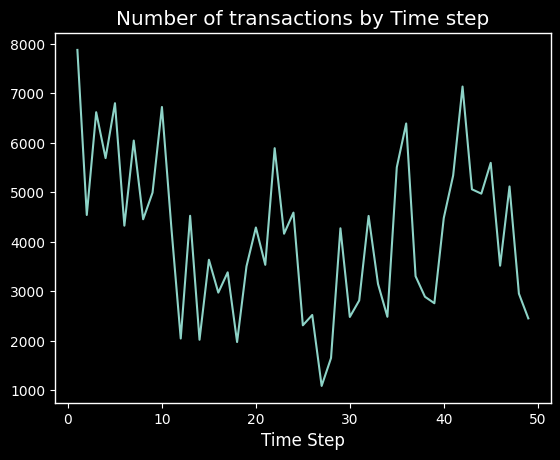

In [29]:
# plt.style.use('ggplot')
group_feature = combined_data.groupby('Time Step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')
plt.grid(visible=None)

In [9]:
subset_data = combined_data.groupby('class').apply(lambda x:x.sample(frac=1/3)).reset_index(drop=True)

In [10]:
subset_data['class'].value_counts()

0    52402
2    14006
1     1515
Name: class, dtype: int64

In [11]:
subset_data.head()

,txId,Time Step,Local_Features_1,Local_Features_2,Local_Features_3,Local_Features_4,Local_Features_5,Local_Features_6,Local_Features_7,Local_Features_8,...,Aggregate_Features_157,Aggregate_Features_158,Aggregate_Features_159,Aggregate_Features_160,Aggregate_Features_161,Aggregate_Features_162,Aggregate_Features_163,Aggregate_Features_164,Aggregate_Features_165,class
0,68454124,10,-0.167984,-0.191139,-0.646376,-0.121970,-0.043875,-0.113002,-0.061584,-0.158531,...,-0.563154,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
1,179540567,9,1.483258,-0.158783,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,1.530934,...,-0.216245,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
2,372980774,22,3.002711,-0.081127,-1.201369,0.028105,-0.043875,-0.113002,0.547008,0.013812,...,-0.600999,0.241128,0.241406,0.135448,-0.010592,0.008288,0.117844,1.519700,1.521399,0
3,363287971,19,-0.131991,-0.094070,-0.646376,-0.121970,-0.043875,-0.113002,-0.061584,-0.121702,...,-0.424391,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,0
4,175429577,9,-0.170581,-0.081127,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161185,...,0.010822,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,0


In [12]:
subset_data.isna().sum()

txId                      0
Time Step                 0
Local_Features_1          0
Local_Features_2          0
Local_Features_3          0
                         ..
Aggregate_Features_162    0
Aggregate_Features_163    0
Aggregate_Features_164    0
Aggregate_Features_165    0
class                     0
Length: 168, dtype: int64

In [13]:
y_cols = ['Unknown','illicit','licit']

X = subset_data[subset_data.columns[2:-1]]
y = subset_data['class']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6, stratify=y,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/6, stratify=y_train,random_state=42)

X_train.reset_index(inplace=True,drop=True)
y_train = y_train.reset_index(drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [15]:
print("Length of train and validation set respectively: ")
len(X_train),len(X_val)

Length of train and validation set respectively: 


(47168, 9434)

In [17]:
%%time
model_RF = RandomForestClassifier(n_jobs=-1).fit(X_train.values,y_train.values)

CPU times: user 1min 11s, sys: 83.6 ms, total: 1min 11s
Wall time: 5.57 s


In [18]:
y_preds = model_RF.predict(X_test.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds)

print("Random Forest Classifier")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

Random Forest Classifier
Precision:0.900 
Recall:0.676 
F1 Score:0.772


In [16]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_scaled = pca.fit_transform(X_train)

In [17]:
explained_var = pca.explained_variance_ratio_
cum_var = explained_var.cumsum()

In [18]:
#Getting the required number of PCA components that explain 95% of the variance
req_comp = np.where(cum_var>=0.95)[0][0] + 1
print(f"The number of required PCA components: ",req_comp)

The number of required PCA components:  57


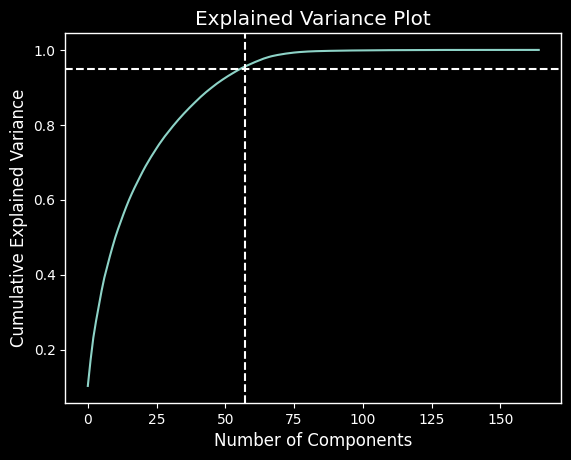

In [31]:
# plt.style.use("ggplot")
plt.plot(cum_var)
plt.axhline(0.95,linestyle='--')
plt.axvline(req_comp,linestyle='--')
plt.title("Explained Variance Plot")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(visible=None)

In [19]:
pca_trans = PCA(n_components=req_comp)

X_train_scaled = pca_trans.fit_transform(X_train)
X_val_scaled = pca_trans.transform(X_val)
X_test_scaled = pca_trans.transform(X_test)

In [42]:
model_pca = RandomForestClassifier(n_jobs=-1)
start = time.time()
model_pca.fit(X_train_scaled,y_train)
print("It took ",round(time.time()-start,2)," seconds")

It took  9.52  seconds


In [20]:
X_recovered_train = pca_trans.inverse_transform(X_train_scaled)
X_recovered_val = pca_trans.inverse_transform(X_val_scaled)

In [21]:
X_recovered_train = pd.DataFrame(X_recovered_train,columns=X_train.columns)

Text(0.5, 1.0, 'The correlation Bar graph for different features')

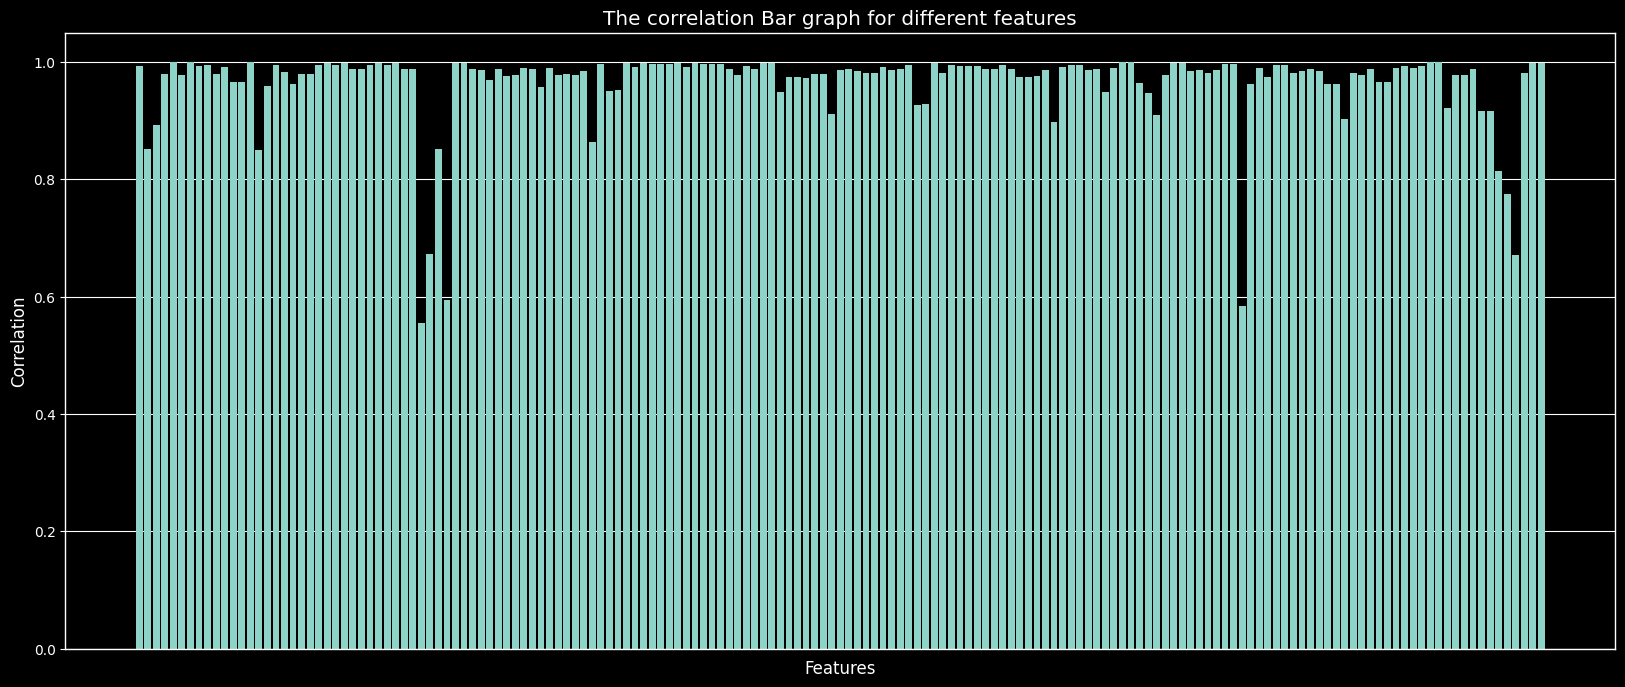

In [34]:
corr_vals = X_train.corrwith(X_recovered_train,axis=0).values
plt.figure(figsize=(20,8))
xs = [str(i) for i in range(1,166)]
plt.bar(xs,corr_vals)
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks([])
plt.title("The correlation Bar graph for different features")

In [44]:
print("Validation accuracy of RF Model: ",model_RF.score(X_val,y_val))
print("Test accuracy of RF Model: ",model_RF.score(X_test,y_test))

/home/athekunal/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/athekunal/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Validation accuracy of RF Model:  0.9398982404070384
Test accuracy of RF Model:  0.9415246003003268


In [43]:
print("Validation accuracy of RF Model: ",model_pca.score(X_val_scaled,y_val))
print("Test accuracy of RF Model: ",model_pca.score(X_test_scaled,y_test))

Validation accuracy of RF Model:  0.8998304006783973
Test accuracy of RF Model:  0.8983305361717163


In [24]:
comps = 2
print(f"Variance explained by first two {comps} is {cum_var[comps+1]} ")

Variance explained by first two 2 is 0.2666565913229439 


In [25]:
pca_2d = PCA(n_components=2)

X_train_2d = pca_2d.fit_transform(X_train)

In [26]:
import random
num_images = 1000

comb_list = list(zip(X_train_2d,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot = [td for (td,l) in selected_list]
y_2d_plot = [l for (td,l) in selected_list]

In [27]:
X_2d_plot = np.array(X_2d_plot)
y_2d_plot = np.array(y_2d_plot)

Text(0, 0.5, 'PC2')

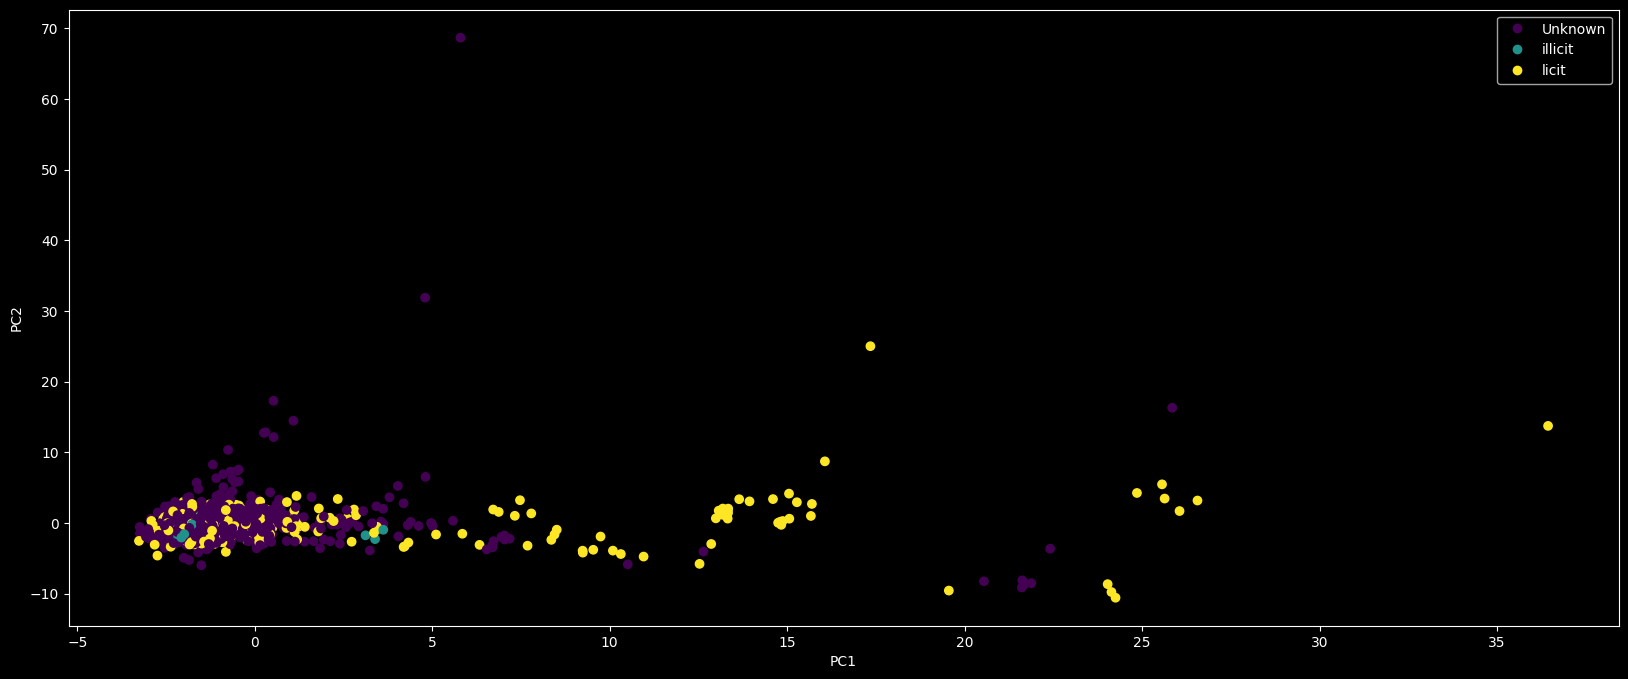

In [28]:
plt.figure(figsize=(20,8))
ax = plt.scatter(X_2d_plot[:,0],X_2d_plot[:,1],c=y_2d_plot,label=y_cols)
plt.legend(handles=ax.legend_elements()[0], labels=y_cols)
plt.xlabel("PC1")
plt.ylabel('PC2')

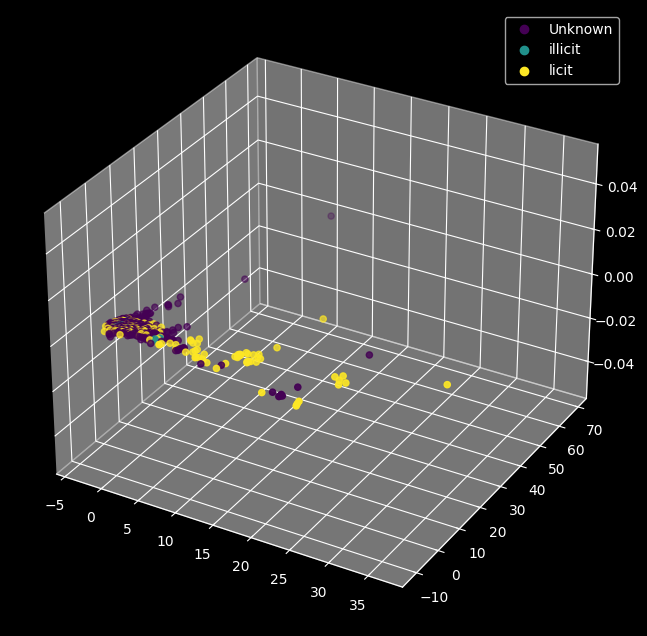

In [29]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
axs = ax.scatter(X_2d_plot[:,0],X_2d_plot[:,1],c=y_2d_plot,label=y_cols)
plt.legend(handles=axs.legend_elements()[0], labels=y_cols)

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=100,n_jobs=-1)

X_tsne = tsne.fit_transform(X_train)

/home/athekunal/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/athekunal/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [52]:
import numpy as np

with open('TSNE.npy', 'wb') as f:
    np.save(f, X_tsne,allow_pickle=True)

with open('TSNE.npy', 'rb') as f:
    X_tsne = np.load(f,allow_pickle=True)

In [53]:
num_images = 1000

comb_list = list(zip(X_tsne,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_tsne = [td for (td,l) in selected_list]
y_2d_plot_tsne = [l for (td,l) in selected_list]

In [54]:
X_2d_plot_tsne = np.array(X_2d_plot_tsne)
y_2d_plot_tsne = np.array(y_2d_plot_tsne)

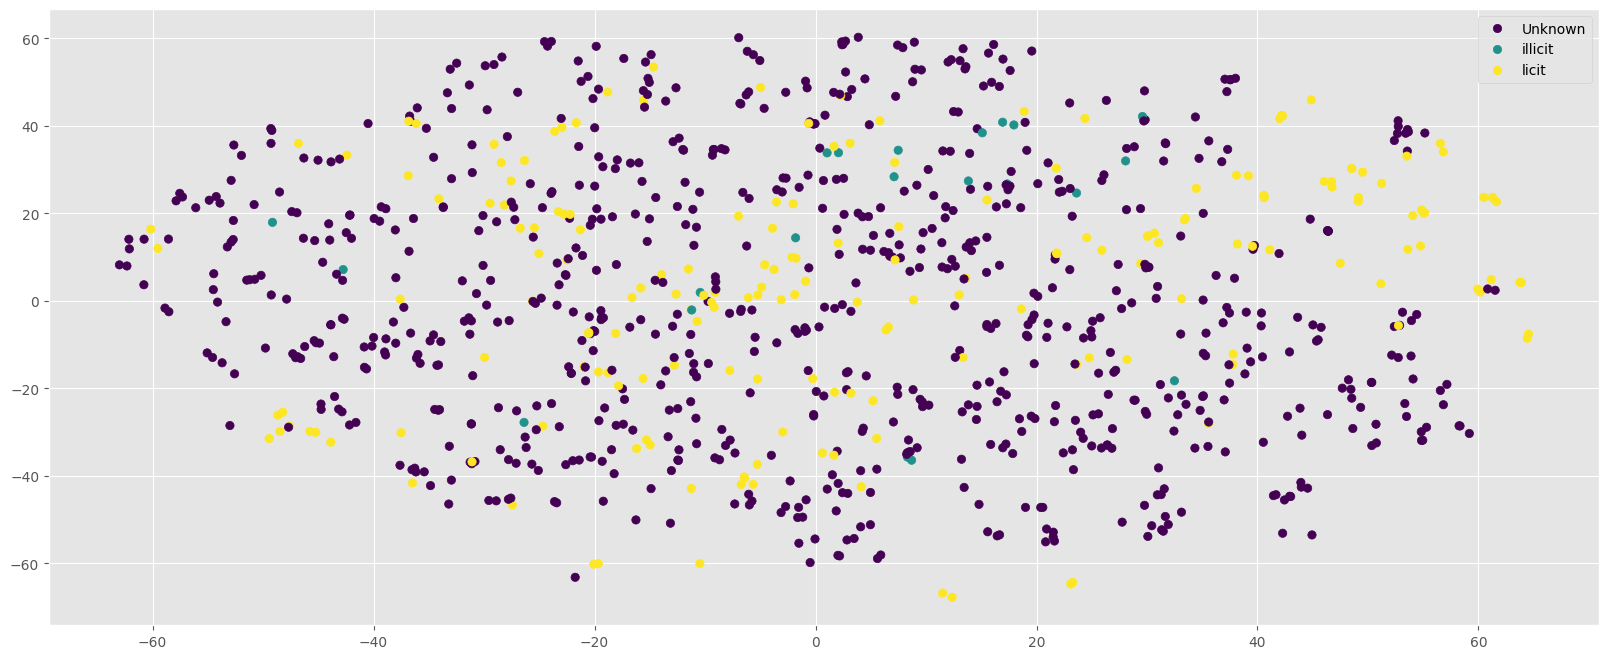

In [55]:
plt.figure(figsize=(20,8))
ax = plt.scatter(X_2d_plot_tsne[:,0],X_2d_plot_tsne[:,1],c=y_2d_plot_tsne,label=y_cols)
plt.legend(handles=ax.legend_elements()[0], labels=y_cols)

In [56]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_jobs=-1)

X_lle = lle.fit_transform(X_train)

In [57]:
import numpy as np

with open('LLE.npy', 'wb') as f:
    np.save(f, X_lle,allow_pickle=True)

with open('LLE.npy', 'rb') as f:
    X_lle = np.load(f,allow_pickle=True)

In [58]:
num_images = 1000

comb_list = list(zip(X_lle,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_lle = [td for (td,l) in selected_list]
y_2d_plot_lle = [l for (td,l) in selected_list]

X_2d_plot_lle = np.array(X_2d_plot_lle)
y_2d_plot_lle = np.array(y_2d_plot_lle)

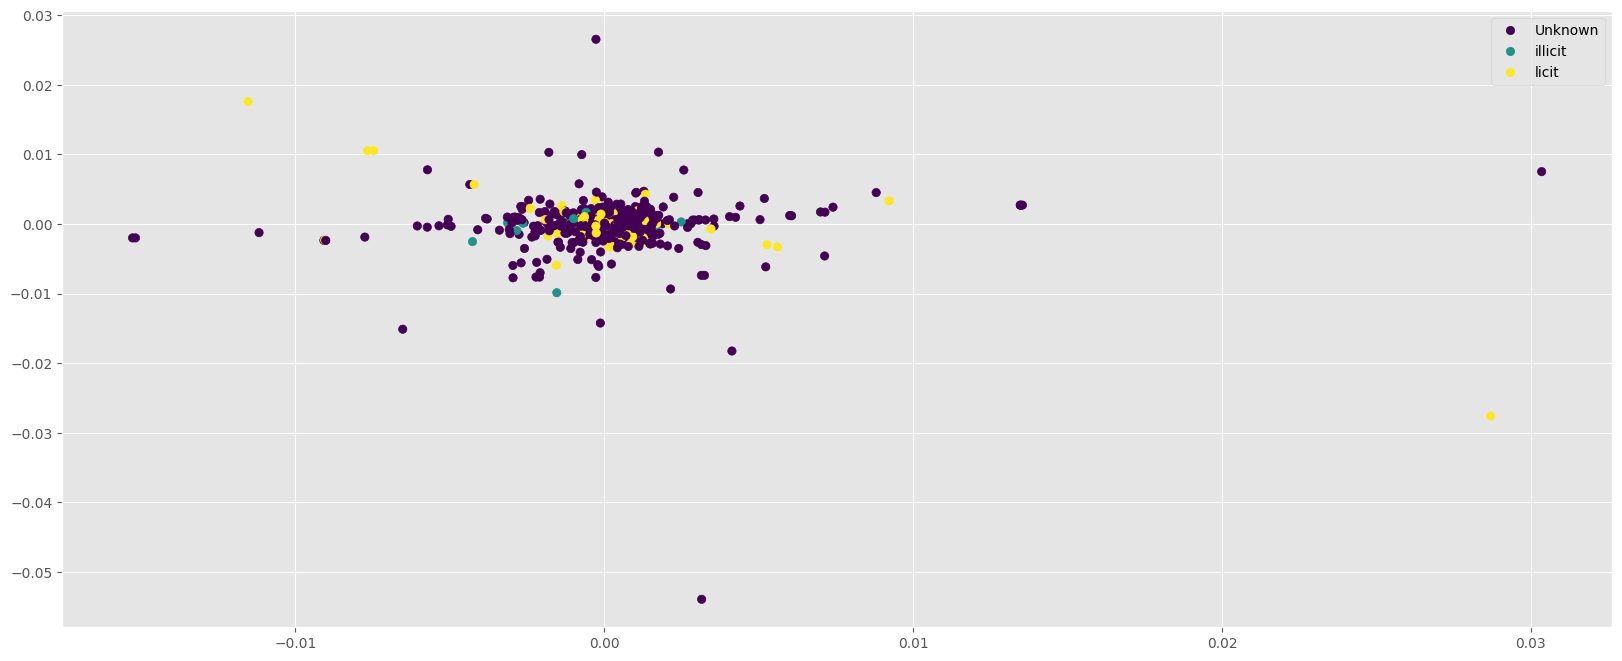

In [59]:
plt.figure(figsize=(20,8))
ax = plt.scatter(X_2d_plot_lle[:,0],X_2d_plot_lle[:,1],c=y_2d_plot_lle,label=y_cols)
plt.legend(handles=ax.legend_elements()[0], labels=y_cols)

## MDS

In [22]:
from sklearn.manifold import MDS
import random
mds = MDS()
X_mds = mds.fit_transform(X_train.sample(frac=1/20,random_state=42))

In [23]:
import numpy as np

with open('MDS.npy', 'wb') as f:
    np.save(f, X_mds,allow_pickle=True)

with open('MDS.npy', 'rb') as f:
    X_mds = np.load(f,allow_pickle=True)

In [24]:
num_images = 1000

comb_list = list(zip(X_mds.tolist(),y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_mds = [td for (td,l) in selected_list]
y_2d_plot_mds = [l for (td,l) in selected_list]

X_2d_plot_mds = np.array(X_2d_plot_mds)
y_2d_plot_mds = np.array(y_2d_plot_mds)

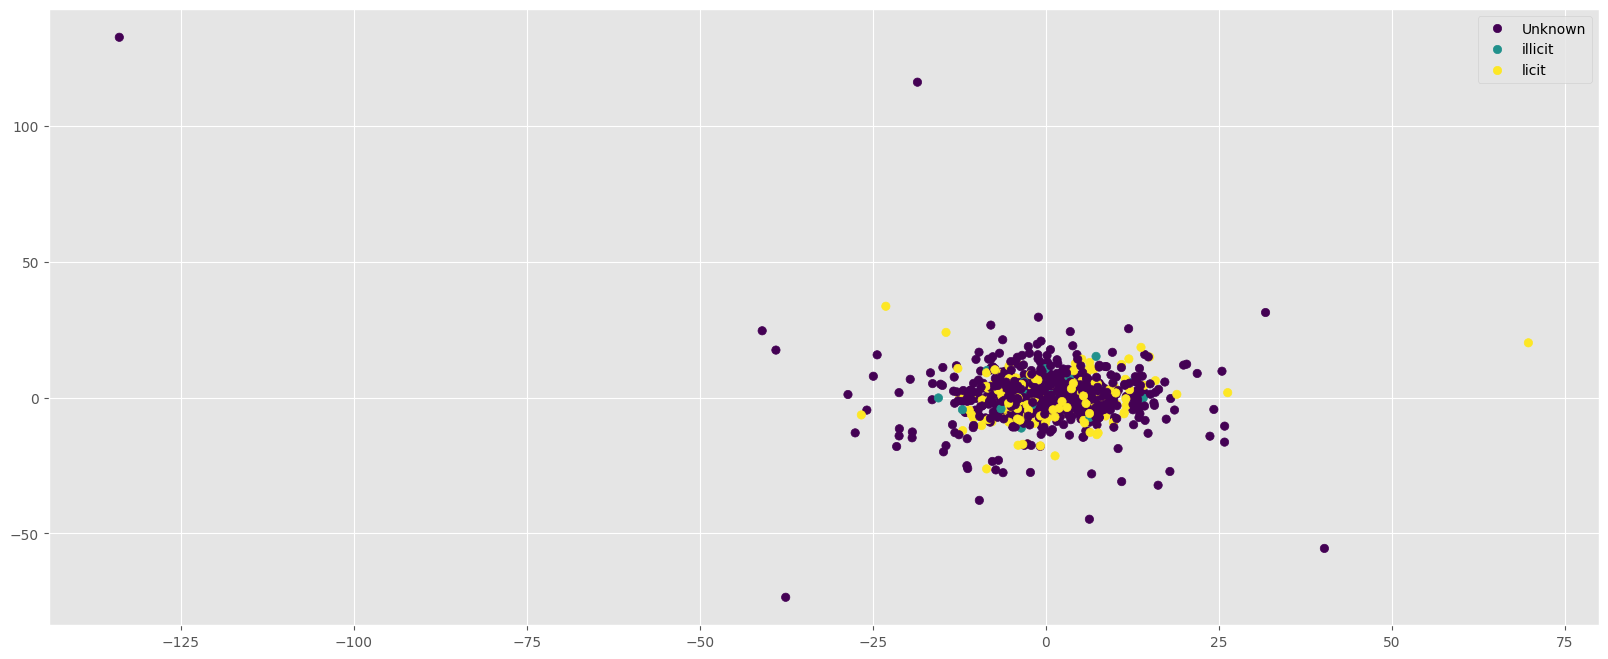

In [25]:
plt.figure(figsize=(20,8))
ax = plt.scatter(X_2d_plot_mds[:,0],X_2d_plot_mds[:,1],c=y_2d_plot_mds,label=y_cols)
plt.legend(handles=ax.legend_elements()[0], labels=y_cols)

## KMeans

In [32]:
X_train_scaled_df = pd.DataFrame(X_train_scaled)
train = pd.concat([X_train_scaled_df,y_train],axis=1)
sample_data = train.groupby('class').apply(lambda x:x.sample(frac=1/4)).reset_index(drop=True)

In [34]:
sample_data['class'].value_counts(normalize=True)

0    0.771475
2    0.206224
1    0.022301
Name: class, dtype: float64

In [37]:
sample_data = sample_data.sample(frac=1)
X_knn_train = sample_data[sample_data.columns[:-1]]
y_knn_train = sample_data['class']

In [38]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm

In [43]:
num_clusters = [i for i in range(2,9)]

kmeans_dicts = {}
for clusters in tqdm(num_clusters):
    kmeans = KMeans(n_clusters=clusters,random_state=42)
    kmeans.fit(X_knn_train)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_knn_train, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_knn_train, cluster_labels)
    kmeans_dicts.update({str(clusters):[kmeans.inertia_,silhouette_avg,sample_silhouette_values]})

100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


In [44]:
inertia_vals = [val[0] for val in kmeans_dicts.values()]
silhoutte_coeffs = [val[1] for val in kmeans_dicts.values()]

Text(0.5, 1.0, 'Inertia Values vs. Number of Centroids')

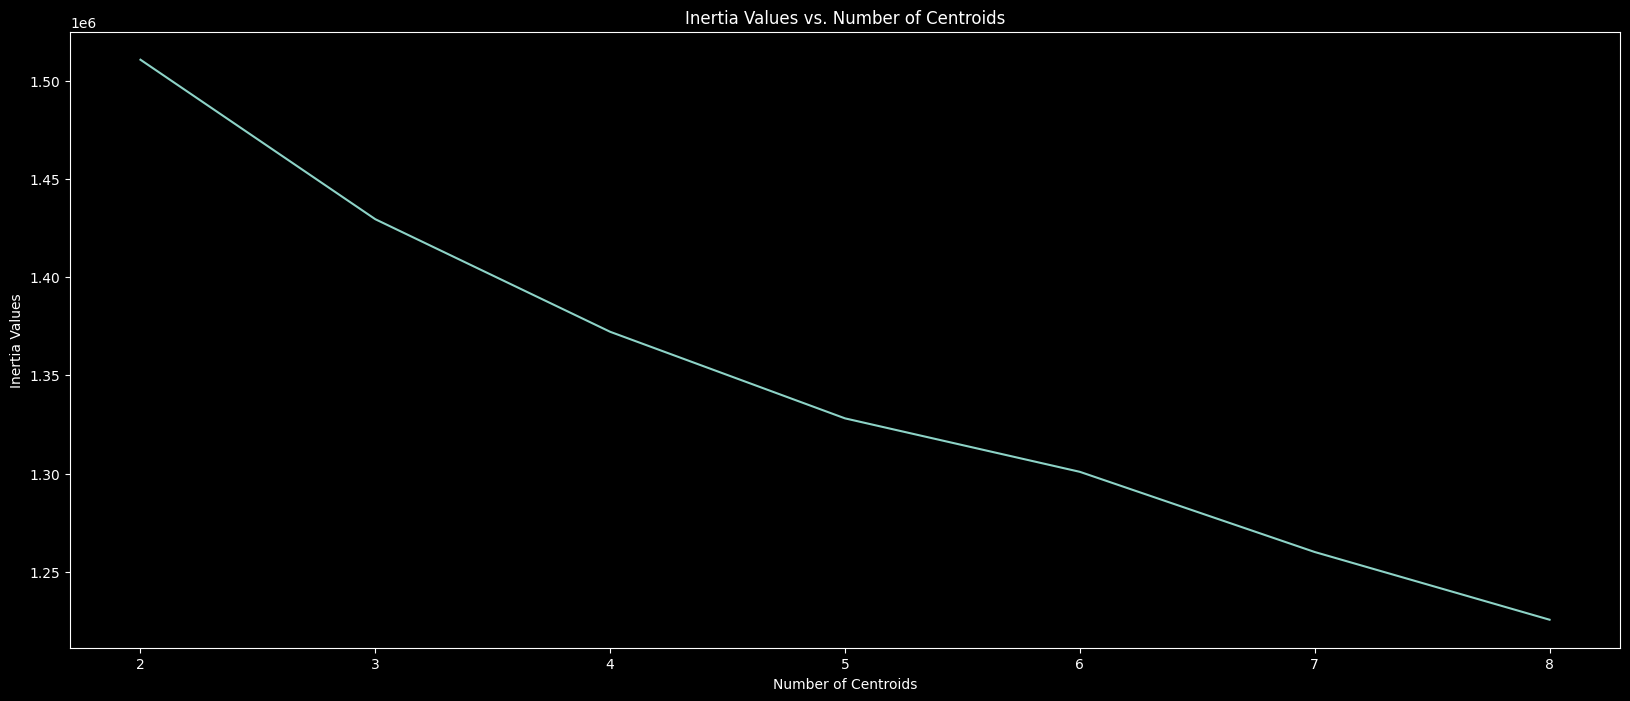

In [45]:
num_clusters = [str(i) for i in num_clusters]
plt.figure(figsize=(20,8))
plt.plot(num_clusters,inertia_vals)
plt.xlabel("Number of Centroids")
plt.ylabel("Inertia Values")
plt.title("Inertia Values vs. Number of Centroids")

Text(0.5, 1.0, 'Silhoutte Coefficients vs. Number of Centroids')

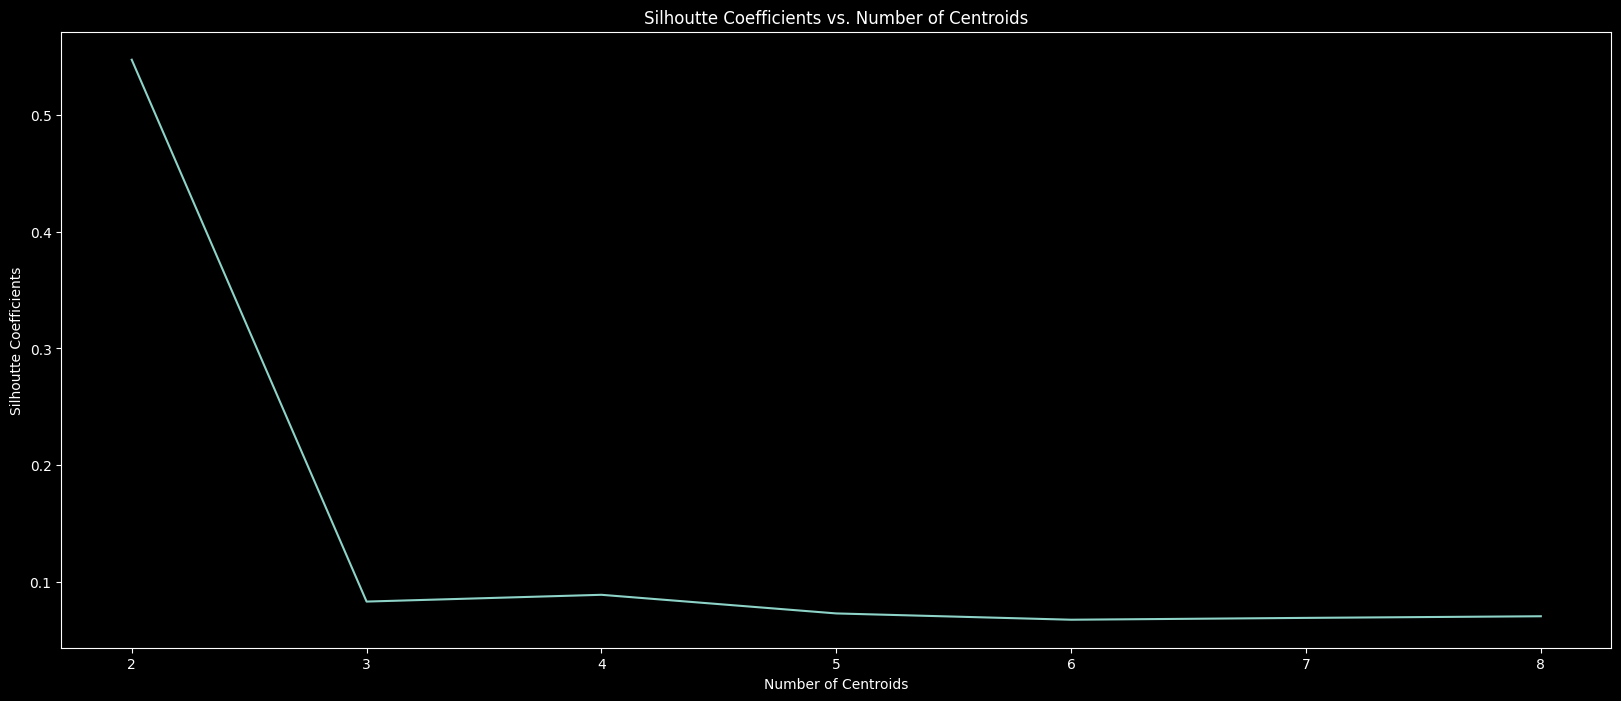

In [46]:
plt.figure(figsize=(20,8))
plt.plot(num_clusters,silhoutte_coeffs)
plt.xlabel("Number of Centroids")
plt.ylabel("Silhoutte Coefficients")
plt.title("Silhoutte Coefficients vs. Number of Centroids")

In [47]:
print(f"The best number of clusters is {2+np.argmax(silhoutte_coeffs)}")

The best number of clusters is 2


In [54]:
import matplotlib.cm as cm

def plot_silhoutte(n_clusters:int,X):
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    clusterer.fit(X_knn_train)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    for idx,y in enumerate(y_cols):
        ax2 = plt.gca()
        sub_df = sample_data[sample_data['class']==idx]
        sub_vals = sub_df.values
        ax2.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
   
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.legend()
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5473335245908221


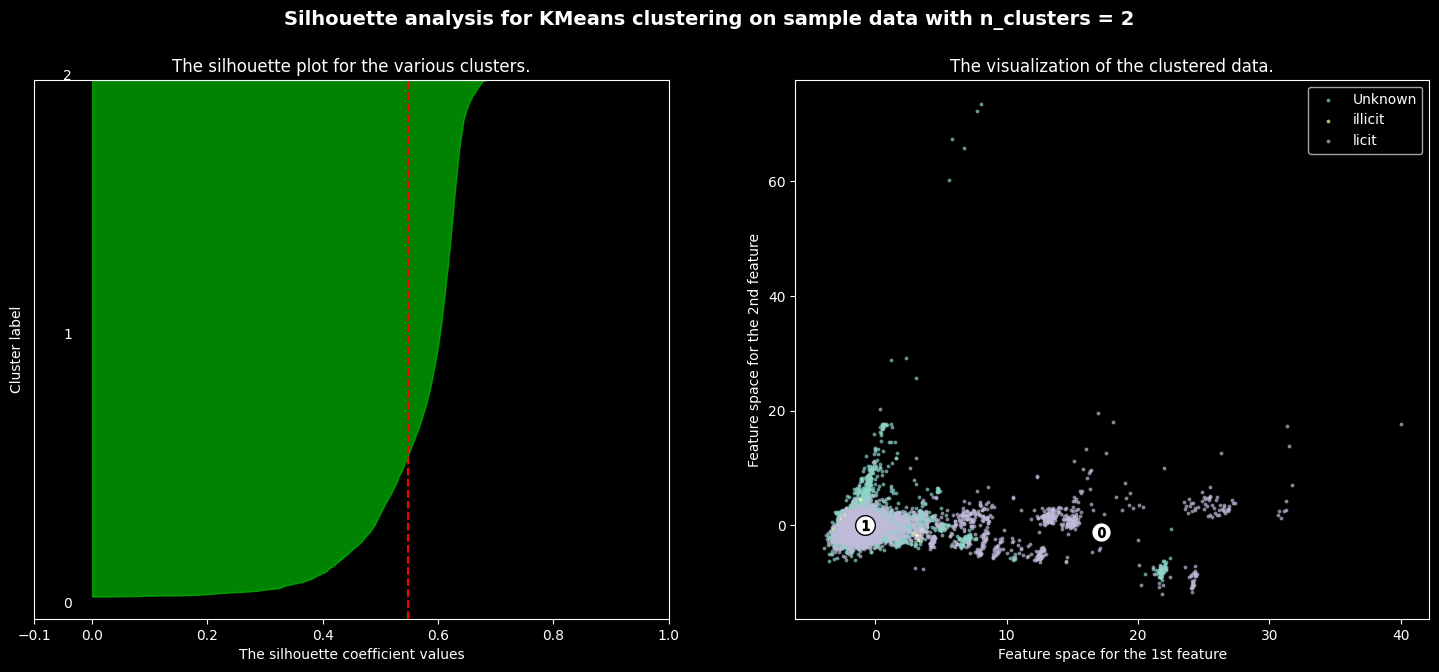

In [55]:
plot_silhoutte(2,X_knn_train.values)

For n_clusters = 3 The average silhouette_score is : 0.08314303268315822


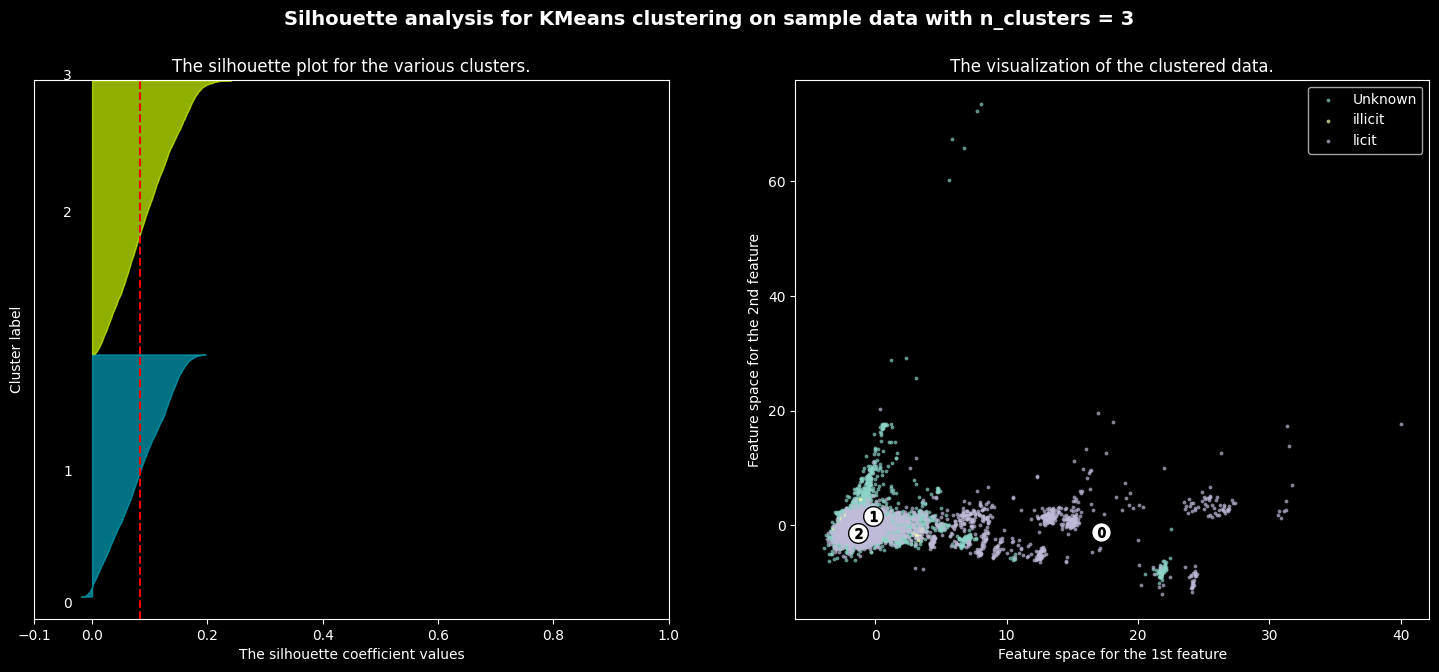

In [56]:
plot_silhoutte(3,X_knn_train.values)

For n_clusters = 4 The average silhouette_score is : 0.08894440883565662


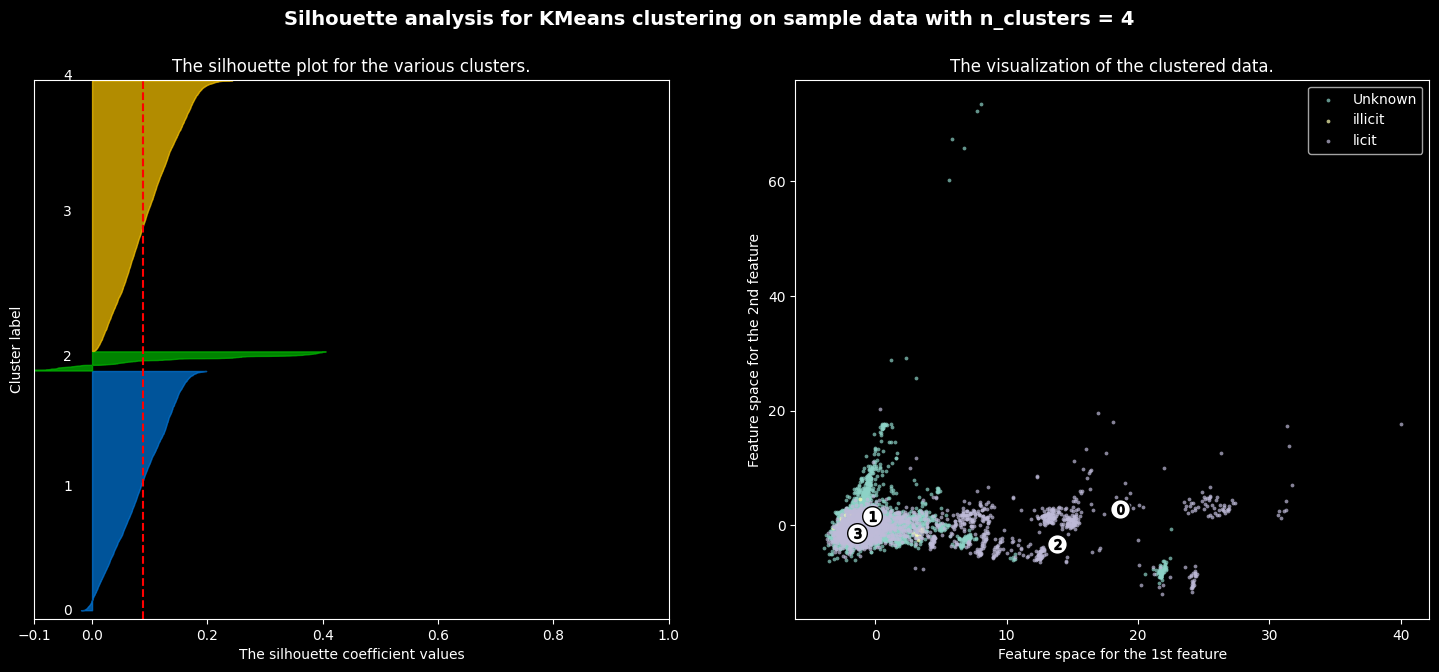

In [58]:
plot_silhoutte(4,X_knn_train.values)

## GMM 

In [60]:
sample_data_gmm = train.groupby('class').apply(lambda x:x.sample(frac=1/5,random_state=42)).reset_index(drop=True)
X_sub_gmm = sample_data_gmm[sample_data_gmm.columns[:-1]]
y_sub_gmm = sample_data_gmm['class']

In [61]:
from sklearn.mixture import GaussianMixture

gmm_full = GaussianMixture(n_components=10,n_init=5,covariance_type="full")
gmm_diag = GaussianMixture(n_components=10,n_init=5,covariance_type="diag")
gmm_tied = GaussianMixture(n_components=10,n_init=5,covariance_type="tied")
gmm_spherical = GaussianMixture(n_components=10,n_init=5,covariance_type="spherical")

In [62]:
def save_dictionary(name:str,dicts_):
    import pickle 

    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(dicts_, f)
def read_dictionary(name:str):        
    with open(f'{name}.pkl', 'rb') as f:
        dicts_ = pickle.load(f)
    return dicts_

In [63]:
from tqdm import tqdm
def get_gaussian_mixture(k_min=5,k_max=20,covariance_type='full'):
    model_gmms = {}
    model_bics = {}
    model_aics = {}
    for n_components in tqdm(range(k_min,k_max+1)):
        gmm_model = GaussianMixture(n_components=n_components,covariance_type=covariance_type,n_init=5).fit(X_sub_gmm)
        model_gmms.update({str(n_components):gmm_model})
        model_bics.update({str(n_components):gmm_model.bic(X_sub_gmm)})
        model_aics.update({str(n_components):gmm_model.aic(X_sub_gmm)})
    plt.figure(figsize=(20,8))
    plt.plot(model_bics.keys(),model_bics.values(),label='BIC')
    plt.plot(model_aics.keys(),model_aics.values(),label='AIC')
    plt.ylabel('Information Criterion')
    plt.xlabel("Number of Clusters")
    plt.legend()
    plt.title(f'{covariance_type} GMM model')
    plt.show()
    
    plt.savefig(f'{covariance_type}.png')

    return model_gmms,model_bics,model_aics

100%|██████████| 4/4 [01:04<00:00, 16.03s/it]


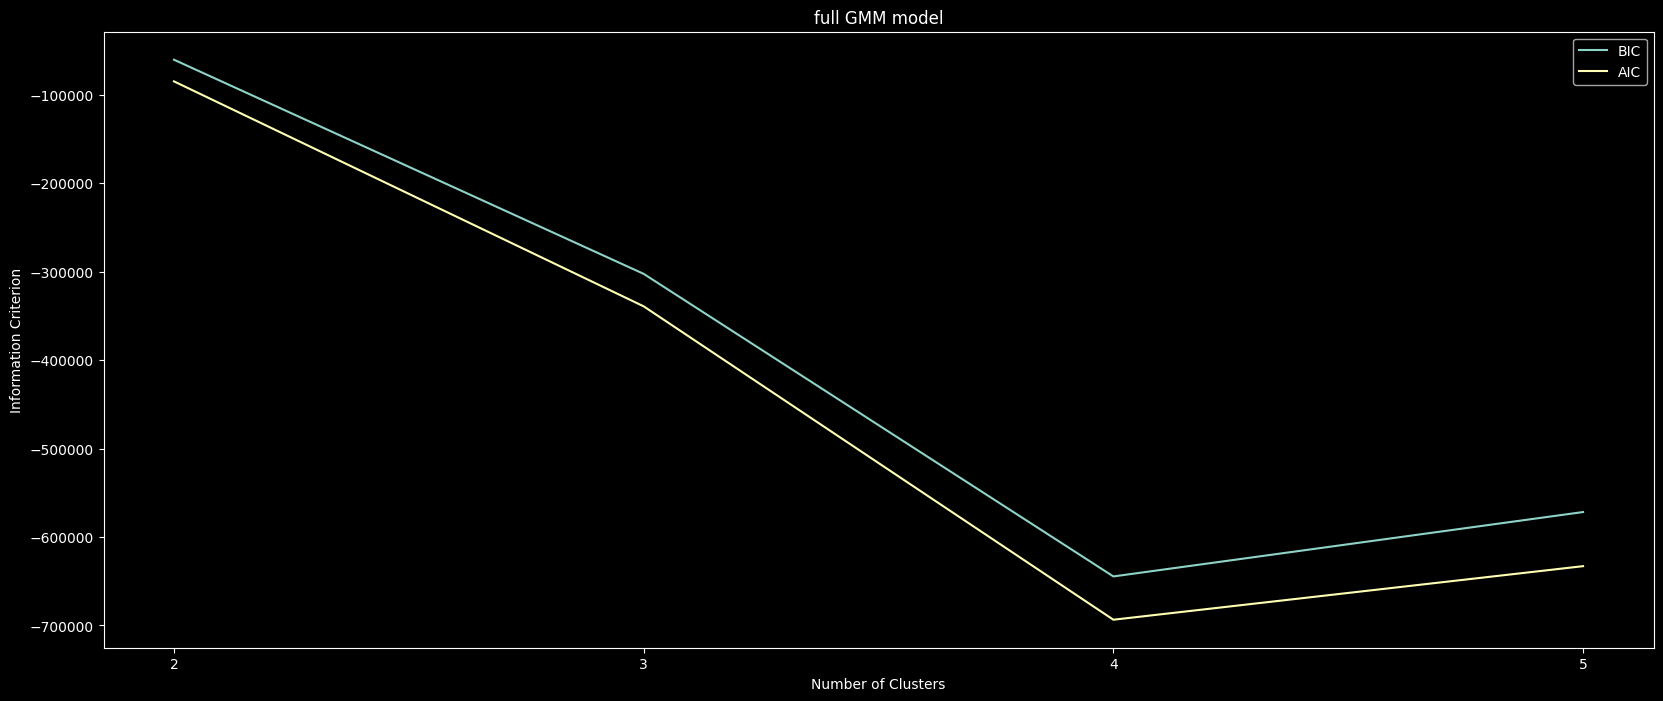

CPU times: user 6min 30s, sys: 9min 40s, total: 16min 10s
Wall time: 1min 4s


<Figure size 640x480 with 0 Axes>

In [64]:
%%time
full_model_gmm,full_bic,full_aic = get_gaussian_mixture(k_min=2,k_max=5)

100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


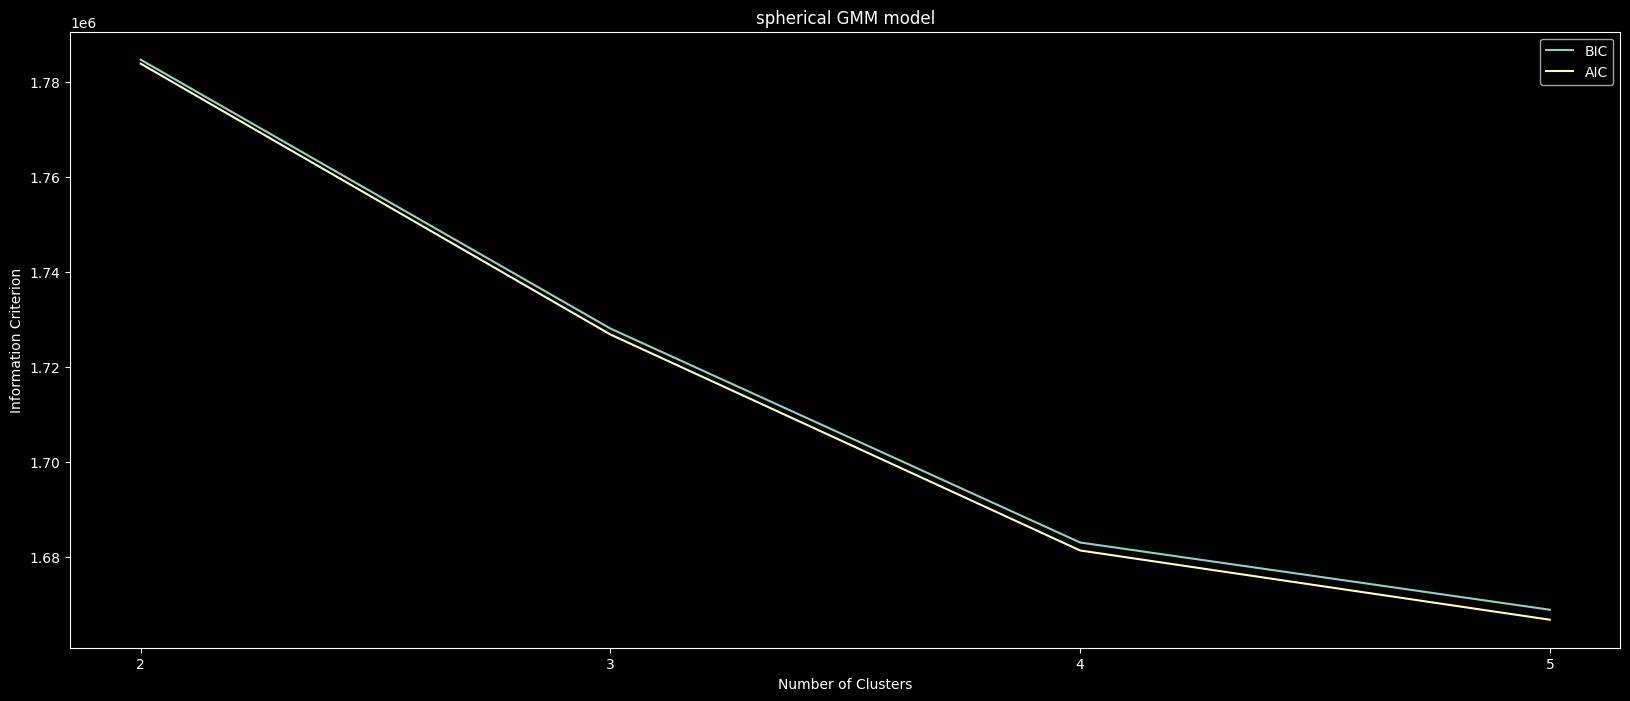

CPU times: user 1min 9s, sys: 37.2 s, total: 1min 46s
Wall time: 7.25 s


<Figure size 640x480 with 0 Axes>

In [65]:
%%time
spherical_model_gmm,spherical_bic,spherical_aic = get_gaussian_mixture(k_min=2,k_max=5,covariance_type='spherical')

save_dictionary('AIC_SPHERICAL',spherical_aic)
save_dictionary('BIC_SPHERICAL',spherical_bic)

100%|██████████| 4/4 [00:14<00:00,  3.66s/it]


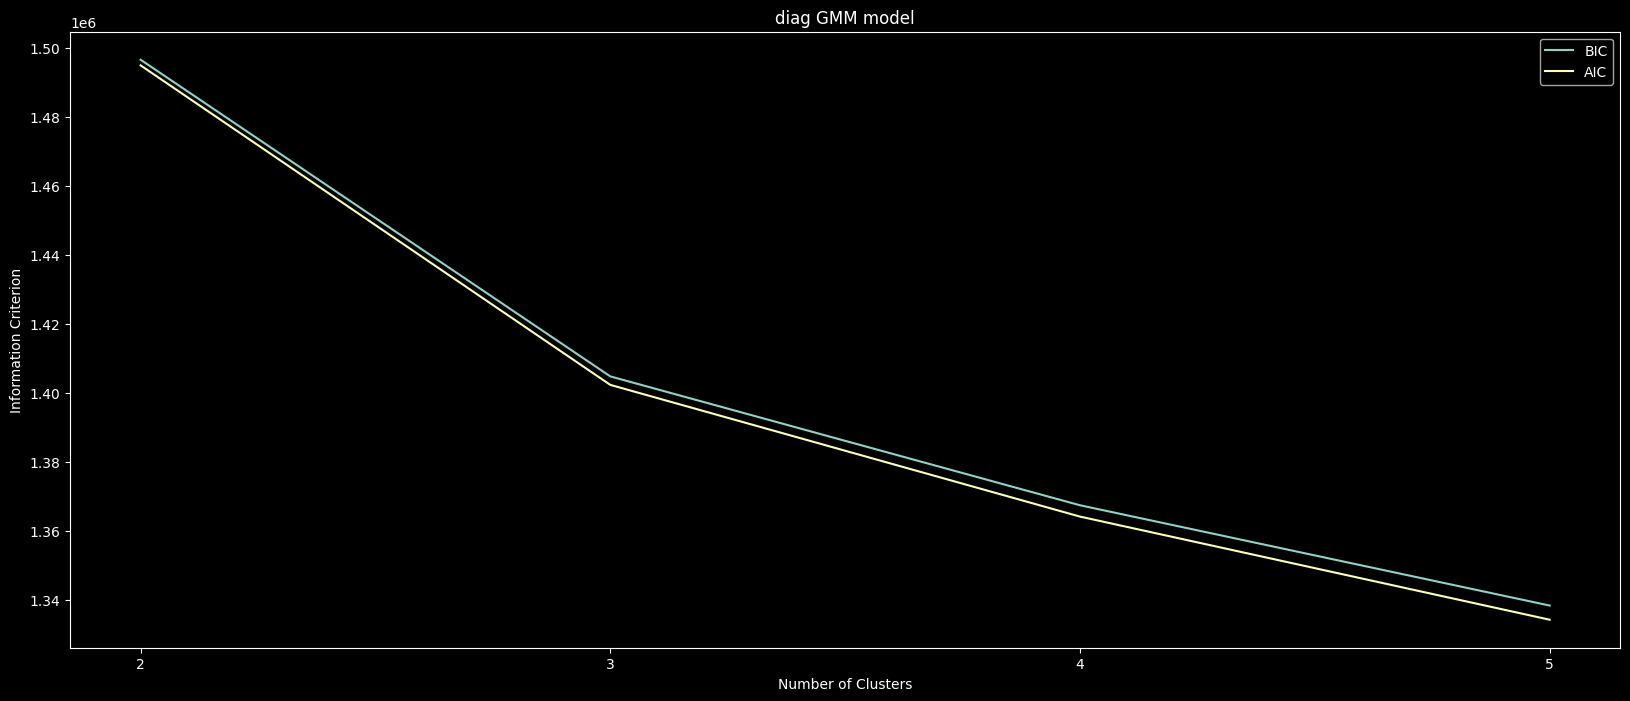

<Figure size 640x480 with 0 Axes>

In [66]:
diag_model_gmm,diag_bic,diag_aic = get_gaussian_mixture(k_min=2,k_max=5,covariance_type='diag')

save_dictionary('AIC_DIAG',diag_aic)
save_dictionary('BIC_DIAG',diag_bic)

100%|██████████| 4/4 [00:25<00:00,  6.42s/it]


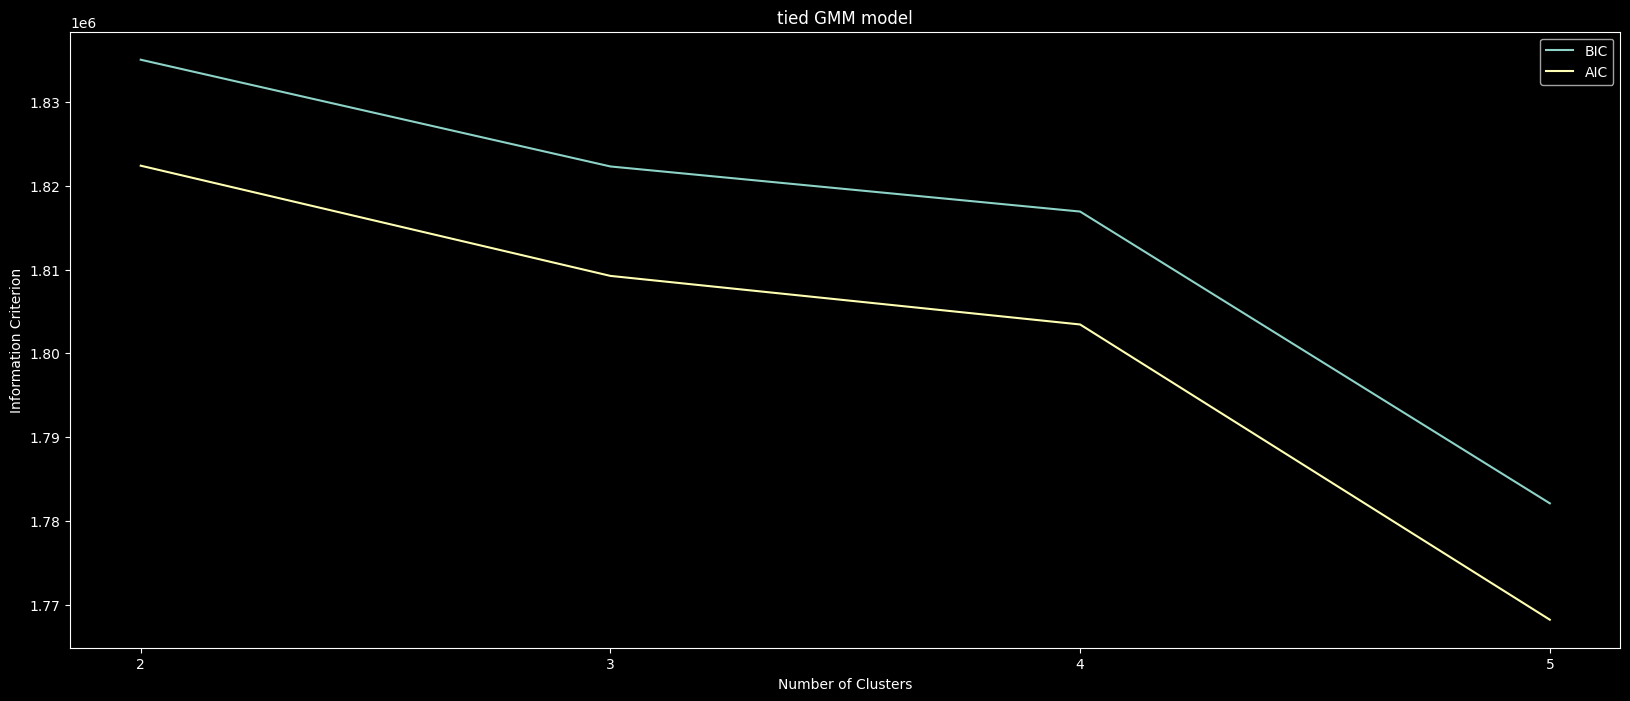

<Figure size 640x480 with 0 Axes>

In [67]:
tied_model_gmm,tied_bic,tied_aic = get_gaussian_mixture(k_min=2,k_max=5,covariance_type='tied')

save_dictionary('AIC_TIED',tied_aic)
save_dictionary('BIC_TIED',tied_bic)

In [68]:
best_gmm_model_full = GaussianMixture(n_components=4).fit(X_sub_gmm)

In [69]:
gmm_samples = best_gmm_model_full.sample(20)
X_sample,y_sample = gmm_samples

In [70]:
X_sample_recoverd = pca_trans.inverse_transform(X_sample)

In [71]:
gmm_plot_df = pd.concat([X_sub_gmm,y_sub_gmm],axis=1)
gmm_plot_df = gmm_plot_df.sample(frac=0.1,random_state=42)
X_gmm_plot = gmm_plot_df[gmm_plot_df.columns[:-1]]
y_gmm_plot = gmm_plot_df['class']

In [72]:
gmm_plot_df['gmm_predicted_label'] = best_gmm_model_full.predict(X_gmm_plot)

In [74]:
num_clsters = 4
y_gmm_cols = [str(i) for i in range(4)]

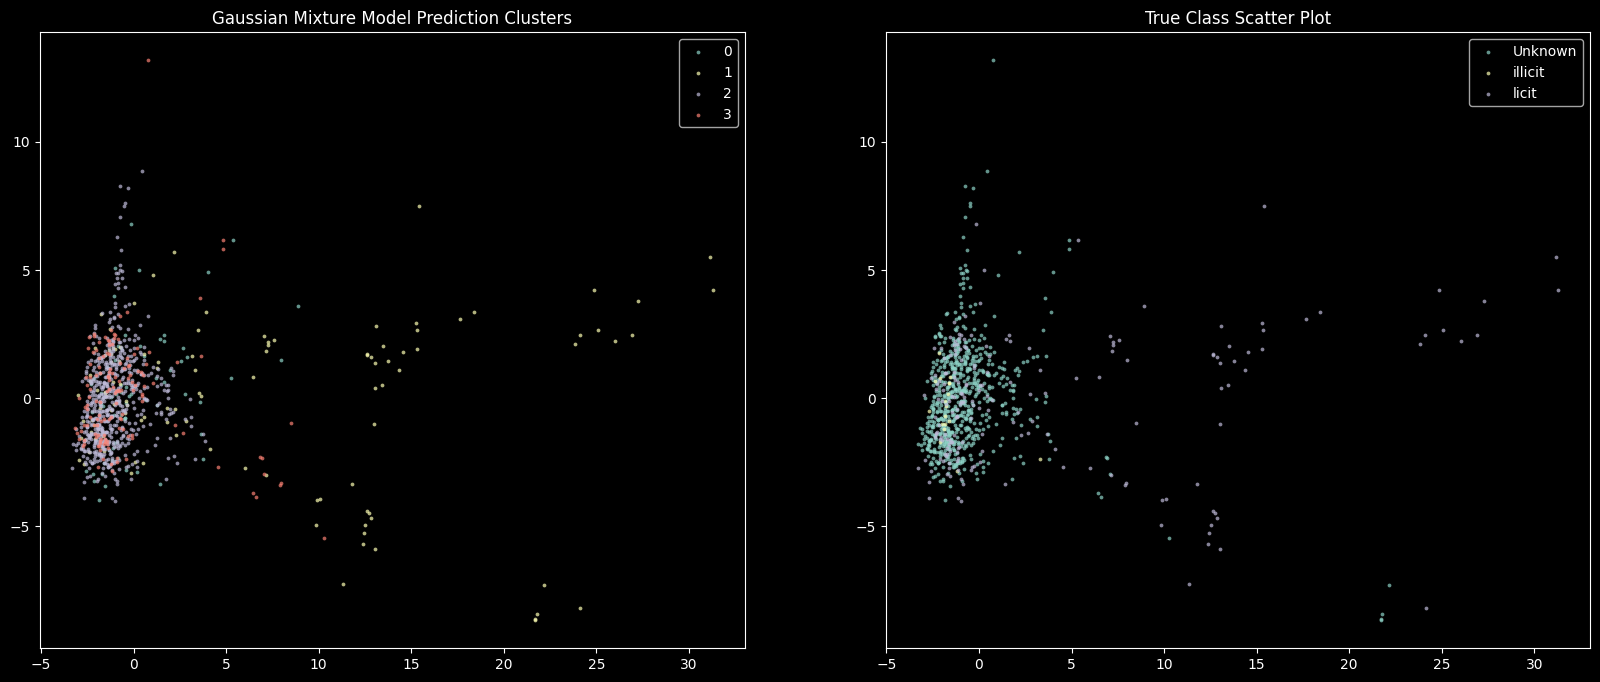

In [75]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(20,8)

for idx,y in enumerate(y_gmm_cols):
    # ax1 = plt.gca()
    sub_df = gmm_plot_df[gmm_plot_df.gmm_predicted_label==idx]
    sub_vals = sub_df.values
    ax1.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
ax1.legend()
ax1.set_title('Gaussian Mixture Model Prediction Clusters')

for idx,y in enumerate(y_cols):
    # ax2 = plt.gca()
    sub_df = gmm_plot_df[gmm_plot_df['class']==idx]
    sub_vals = sub_df.values
    ax2.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
ax2.set_title('True Class Scatter Plot')
ax2.legend()
plt.show()